In [3]:
using ForwardDiff, Plots, Statistics, LinearAlgebra, OnlineStats, Distributions, Random, CUDA, CSV, DataFrames

using Sofia, Geraldine

# Backend
plotly()

┌ Info: Precompiling Geraldine [c0fffcf4-b2fb-46e8-8a34-03ca56aefa66]
└ @ Base loading.jl:1278
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken fo

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Package Geraldine does not have Pkg in its dependencies:
│ - If you have Geraldine checked out for development and have
│   added Pkg as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Geraldine
└ Loading Pkg into Geraldine from project dependency, future warnings for Geraldine are suppressed.
┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots C:\Users

Plots.PlotlyBackend()

$$ f(x) = \dfrac{1}{N} \sum_{i=1}^N e^{-\frac{1}{2}\Vert \xi_i x \Vert^2} $$

In [4]:
include("Exponential_Stochastic.jl")

Hessian_vector_product_SExp (generic function with 1 method)

## Creation Stochastic model 

In [5]:
struct Model_Exp{T <: IsUpdatable} <: Sofia.AbstractStochasticModel{T}
    samples::Vector
    
    function Model_Exp(samples::Vector, upd::Bool = false)
        UPD = upd ? Updatable : NotUpdatable
        return new{UPD}(samples)
    end
end

In [6]:
nb_pop = 100_000

samples = randn(nb_pop) .+ 1.0

mo_exp = Model_Exp(samples)

Model_Exp{NotUpdatable}([2.380882573523849, 3.4694546731933795, 1.3486648803209966, 1.0603544965432203, 1.249571118671077, 1.0875805004470889, 1.554127786464443, 0.7311895332931426, 1.3322514396495153, 1.3908904179316226  …  1.956422735724888, 2.3245629792465596, 0.7466937043261911, 2.8957777882652174, 1.1413832047838042, 0.2143782449503907, 0.715177033907668, 1.5994896108155796, 0.13313430764308165, -0.12398810704913132])

In [7]:
function Sofia.Nobs(mo::Model_Exp)
   return size(mo.samples, 1)
end

Sofia.Nobs(mo_exp)

100000

## Verification functions in Exponential

In [8]:
dim = 10

beta = rand(dim)

N = 100;

In [9]:
# definition F 
function Sofia.F(x::Array{T,1}, mo::Model_Exp ; sample = 1:Nobs(mo)) where T
   return Exponential_Sto(x, mo.samples[sample])
end

@show F(beta, mo_exp)

# definition 
function Sofia.Fs(x::Array{T,1}, mo::Model_Exp ; sample = 1:Nobs(mo)) where T
   return Exponential_Sto_inds(x, mo.samples[sample])
end

@show mean(Sofia.Fs(beta, mo_exp)) - F(beta, mo_exp)

Sofia.Fs(beta, mo_exp; sample = 1:2)

F(beta, mo_exp) = -0.3100166737494168
mean(Sofia.Fs(beta, mo_exp)) - F(beta, mo_exp) = 6.661338147750939e-16


2-element Array{Float64,1}:
 -2.8840999275528523e-5
 -2.288022166699793e-10

In [10]:
# ------------------- gradient -----------------------
function Sofia.grad!(x::Vector, mo::Model_Exp, stack::Vector ; sample=1:Nobs(mo))
    stack[:] = Exponential_Sto_Grad(x, mo.samples[sample])[:]
end

function Sofia.grad(x::Vector, mo::Model_Exp ; sample=1:Nobs(mo))
    return Exponential_Sto_Grad(x, mo.samples[sample])
end

function Sofia.grads(x::Vector, mo::Model_Exp ; sample=1:Nobs(mo))
    return Exponential_Sto_Grads(x, mo.samples[sample])
end

function Sofia.grads!(x::Vector, mo::Model_Exp, stack::Array{Vector, 1}; sample=1:Nobs(mo))
    result = Exponential_Sto_Grads(x, mo.samples[sample])
    for i in 1:length(sample)
        stack[i] = result[:, i]
    end
end

In [11]:
stack = Array{Float64, 1}(undef, dim)
Sofia.grad!(beta, mo_exp, stack; sample=1:N)

# vector stack
show(stdout, "text/plain", stack)

# diff with forward diff
ForwardDiff.gradient(t -> Sofia.F(t, mo_exp ; sample=1:N), beta) - stack

# diff with forward diff
ForwardDiff.gradient(t -> Sofia.F(t, mo_exp ; sample=1:N), beta) - Sofia.grad(beta, mo_exp;sample=1:N)

10-element Array{Float64,1}:
 0.04510168603549709
 0.07334041681595575
 0.06826694767694497
 0.03283297917085987
 0.011742636817452514
 0.07006281080340411
 0.04131708707314843
 0.06325076647842344
 0.006391559822507415
 0.016607193110458343

10-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -1.734723475976807e-18
  0.0

In [12]:
# Matrix of gradients
all_g = Sofia.grads(beta, mo_exp ; sample=1:N)

10×100 Array{Float64,2}:
 9.09876e-5   1.53278e-9   0.0353629   0.0786871  …  0.00134774   0.0244457
 0.000147956  2.49247e-9   0.057504    0.127954      0.00219158   0.0397515
 0.000137721  2.32004e-9   0.053526    0.119103      0.00203997   0.0370016
 6.62369e-5   1.11583e-9   0.0257433   0.0572824     0.000981123  0.0177959
 2.36895e-5   3.99072e-10  0.00920704  0.0204869     0.000350896  0.00636467
 0.000141344  2.38108e-9   0.0549341   0.122236   …  0.00209363   0.037975
 8.33526e-5   1.40416e-9   0.0323955   0.0720843     0.00123465   0.0223944
 0.000127601  2.14957e-9   0.049593    0.110351      0.00189008   0.0342828
 1.28943e-5   2.17216e-10  0.00501143  0.0111511     0.000190994  0.00346431
 3.35032e-5   5.64394e-10  0.0130212   0.0289739     0.00049626   0.00900133

In [13]:
# ----------------- Hessian ---------------------------

function Sofia.H!(x::Vector, mo::Model_Exp, stack::Matrix; sample=1:Nobs(mo))
    stack[:,:] = Exponential_Sto_Hessian(x, mo.samples[sample])[:,:]
end

function Sofia.Hdotv(x::Vector, mo::AbstractModel, v::Vector; sample=1:Nobs(mo))
    return Hessian_vector_product_SExp(x, mo.samples[sample], v)
end

function Sofia.Hdotv!(x::Vector, mo::AbstractModel, v::Vector, stack::Vector; sample=1:Nobs(mo))
    stack[:] = Hdotv(x, mo, v; sample = sample)
end

In [14]:
v = rand(dim)

Hdotv(beta, mo_exp, v; sample=1:N) - ForwardDiff.hessian(t -> Sofia.F(t, mo_exp; sample=1:N), beta)*v

10-element Array{Float64,1}:
 -2.6020852139652106e-18
 -9.71445146547012e-17
 -2.7755575615628914e-17
  3.469446951953614e-18
 -6.071532165918825e-18
 -1.5265566588595902e-16
  4.163336342344337e-17
  2.7755575615628914e-17
  6.245004513516506e-17
  3.122502256758253e-17

# Minimizing with Geraldine

In [48]:
################################################################################
#                   Tests minimization
dim = 2

x0 = rand(Normal(20, 1), dim)

2-element Array{Float64,1}:
 22.545278228811334
 19.09856045400314

In [49]:
Sofia.grad(x0, mo_exp ; sample=1:Nobs(mo_exp))

2-element Array{Float64,1}:
 0.0005145649314936526
 0.0004358983442964445

In [50]:
norm(Sofia.grad(x0, mo_exp ; sample=1:Nobs(mo_exp)))

0.0006743770720327383

In [51]:
norm(Sofia.grad(x0, mo_exp ; sample=1:100))


0.0005902878568064464

In [52]:
# SGD
mySGD =  Geraldine.AdamConstStep(0.1, 0.9, 0.99)
accSGD =  Accumulator(ValueAccumulator(),  ParamAccumulator())
samplingStrategy =  RandomSampling(;N = 100, NMax = Nobs(mo_exp))
state =  AdamState(copy(x0), samplingStrategy)

state, accumulatorSGD = mySGD(mo_exp, state ; sp =  Geraldine.StopParam(eps_g = 1e-8, NMax = 1000), accumulator = accSGD)

resultSGD = Geraldine.structToDict(accumulatorSGD)

paramSGD = resultSGD[:ParamAccumulator]
fSGD = resultSGD[:ValueAccumulator]

Algorithm of type : AdamConstStep{Float64}
Nmax reached ? 
k = 0  and  max = 1000

--------------------------------------------------------------------------------
Iteration 0
-0.01629292367052778
--------------------------------------------------------------------------------
Nmax reached ? 
k = 1  and  max = 1000

--------------------------------------------------------------------------------
Iteration 1
-0.03442871163252596
--------------------------------------------------------------------------------
Nmax reached ? 
k = 2  and  max = 1000

--------------------------------------------------------------------------------
Iteration 2
-0.009127638118190645
--------------------------------------------------------------------------------
Nmax reached ? 
k = 3  and  max = 1000

--------------------------------------------------------------------------------
Iteration 3
-0.03415393900791784
--------------------------------------------------------------------------------
Nmax reached ? 


Nmax reached ? 
k = 45  and  max = 1000

--------------------------------------------------------------------------------
Iteration 45
-0.009193785991273469
--------------------------------------------------------------------------------
Nmax reached ? 
k = 46  and  max = 1000

--------------------------------------------------------------------------------
Iteration 46
-0.018785593288590304
--------------------------------------------------------------------------------
Nmax reached ? 
k = 47  and  max = 1000

--------------------------------------------------------------------------------
Iteration 47
-0.015432576825992528
--------------------------------------------------------------------------------
Nmax reached ? 
k = 48  and  max = 1000

--------------------------------------------------------------------------------
Iteration 48
-0.015986522928203472
--------------------------------------------------------------------------------
Nmax reached ? 
k = 49  and  max = 1000

-------

Nmax reached ? 
k = 86  and  max = 1000

--------------------------------------------------------------------------------
Iteration 86
-0.053330213050931885
--------------------------------------------------------------------------------
Nmax reached ? 
k = 87  and  max = 1000

--------------------------------------------------------------------------------
Iteration 87
-0.02988511778794351
--------------------------------------------------------------------------------
Nmax reached ? 
k = 88  and  max = 1000

--------------------------------------------------------------------------------
Iteration 88
-0.04647738644965657
--------------------------------------------------------------------------------
Nmax reached ? 
k = 89  and  max = 1000

--------------------------------------------------------------------------------
Iteration 89
-0.040109974857496074
--------------------------------------------------------------------------------
Nmax reached ? 
k = 90  and  max = 1000

---------


--------------------------------------------------------------------------------
Iteration 127
-0.06382768988267364
--------------------------------------------------------------------------------
Nmax reached ? 
k = 128  and  max = 1000

--------------------------------------------------------------------------------
Iteration 128
-0.056471234027955196
--------------------------------------------------------------------------------
Nmax reached ? 
k = 129  and  max = 1000

--------------------------------------------------------------------------------
Iteration 129
-0.0917369487122946
--------------------------------------------------------------------------------
Nmax reached ? 
k = 130  and  max = 1000

--------------------------------------------------------------------------------
Iteration 130
-0.05807642517380139
--------------------------------------------------------------------------------
Nmax reached ? 
k = 131  and  max = 1000

-------------------------------------------

Iteration 166
-0.6329062902209728
--------------------------------------------------------------------------------
Nmax reached ? 
k = 167  and  max = 1000

--------------------------------------------------------------------------------
Iteration 167
-0.779720373767087
--------------------------------------------------------------------------------
Nmax reached ? 
k = 168  and  max = 1000

--------------------------------------------------------------------------------
Iteration 168
-0.8853088968439787
--------------------------------------------------------------------------------
Nmax reached ? 
k = 169  and  max = 1000

--------------------------------------------------------------------------------
Iteration 169
-0.9795550637015527
--------------------------------------------------------------------------------
Nmax reached ? 
k = 170  and  max = 1000

--------------------------------------------------------------------------------
Iteration 170
-0.9883874455415483
---------------

-0.9946707836735793
--------------------------------------------------------------------------------
Nmax reached ? 
k = 209  and  max = 1000

--------------------------------------------------------------------------------
Iteration 209
-0.9976664407049327
--------------------------------------------------------------------------------
Nmax reached ? 
k = 210  and  max = 1000

--------------------------------------------------------------------------------
Iteration 210
-0.9979205230946878
--------------------------------------------------------------------------------
Nmax reached ? 
k = 211  and  max = 1000

--------------------------------------------------------------------------------
Iteration 211
-0.9995196851918665
--------------------------------------------------------------------------------
Nmax reached ? 
k = 212  and  max = 1000

--------------------------------------------------------------------------------
Iteration 212
-0.999943680058018
-----------------------------

Nmax reached ? 
k = 254  and  max = 1000

--------------------------------------------------------------------------------
Iteration 254
-0.9999508080137477
--------------------------------------------------------------------------------
Nmax reached ? 
k = 255  and  max = 1000

--------------------------------------------------------------------------------
Iteration 255
-0.9999626241108329
--------------------------------------------------------------------------------
Nmax reached ? 
k = 256  and  max = 1000

--------------------------------------------------------------------------------
Iteration 256
-0.9999745737749858
--------------------------------------------------------------------------------
Nmax reached ? 
k = 257  and  max = 1000

--------------------------------------------------------------------------------
Iteration 257
-0.9999884444528198
--------------------------------------------------------------------------------
Nmax reached ? 
k = 258  and  max = 1000

------

--------------------------------------------------------------------------------
Iteration 291
-0.999999483677772
--------------------------------------------------------------------------------
Nmax reached ? 
k = 292  and  max = 1000

--------------------------------------------------------------------------------
Iteration 292
-0.9999998110415642
--------------------------------------------------------------------------------
Nmax reached ? 
k = 293  and  max = 1000

--------------------------------------------------------------------------------
Iteration 293
-0.9999999924778009
--------------------------------------------------------------------------------
Nmax reached ? 
k = 294  and  max = 1000

--------------------------------------------------------------------------------
Iteration 294
-0.9999998840998693
--------------------------------------------------------------------------------
Nmax reached ? 
k = 295  and  max = 1000

-------------------------------------------------

k = 326  and  max = 1000

--------------------------------------------------------------------------------
Iteration 326
-0.9999999805460524
--------------------------------------------------------------------------------
Nmax reached ? 
k = 327  and  max = 1000

--------------------------------------------------------------------------------
Iteration 327
-0.9999999738066454
--------------------------------------------------------------------------------
Nmax reached ? 
k = 328  and  max = 1000

--------------------------------------------------------------------------------
Iteration 328
-0.9999999623919926
--------------------------------------------------------------------------------
Nmax reached ? 
k = 329  and  max = 1000

--------------------------------------------------------------------------------
Iteration 329
-0.9999999821271346
--------------------------------------------------------------------------------
Nmax reached ? 
k = 330  and  max = 1000

----------------------

Nmax reached ? 
k = 372  and  max = 1000

--------------------------------------------------------------------------------
Iteration 372
-0.9999999999955541
--------------------------------------------------------------------------------
Nmax reached ? 
k = 373  and  max = 1000

--------------------------------------------------------------------------------
Iteration 373
-0.9999999998607838
--------------------------------------------------------------------------------
Nmax reached ? 
k = 374  and  max = 1000

--------------------------------------------------------------------------------
Iteration 374
-0.9999999996925386
--------------------------------------------------------------------------------
Nmax reached ? 
k = 375  and  max = 1000

--------------------------------------------------------------------------------
Iteration 375
-0.9999999997730469
--------------------------------------------------------------------------------
Nmax reached ? 
k = 376  and  max = 1000

------

--------------------------------------------------------------------------------
Nmax reached ? 
k = 410  and  max = 1000

--------------------------------------------------------------------------------
Iteration 410
-0.999999999997175
--------------------------------------------------------------------------------
Nmax reached ? 
k = 411  and  max = 1000

--------------------------------------------------------------------------------
Iteration 411
-0.9999999999944025
--------------------------------------------------------------------------------
Nmax reached ? 
k = 412  and  max = 1000

--------------------------------------------------------------------------------
Iteration 412
-0.9999999999951971
--------------------------------------------------------------------------------
Nmax reached ? 
k = 413  and  max = 1000

--------------------------------------------------------------------------------
Iteration 413
-0.9999999999982758
-------------------------------------------------

-0.9999999999998953
--------------------------------------------------------------------------------
Nmax reached ? 
k = 452  and  max = 1000

--------------------------------------------------------------------------------
Iteration 452
-0.9999999999999579
--------------------------------------------------------------------------------
Nmax reached ? 
k = 453  and  max = 1000

--------------------------------------------------------------------------------
Iteration 453
-0.9999999999999802
--------------------------------------------------------------------------------
Nmax reached ? 
k = 454  and  max = 1000

--------------------------------------------------------------------------------
Iteration 454
-0.9999999999999508
--------------------------------------------------------------------------------
Nmax reached ? 
k = 455  and  max = 1000

--------------------------------------------------------------------------------
Iteration 455
-0.9999999999999153
----------------------------

Iteration 490
-0.9999999999999986
--------------------------------------------------------------------------------
Nmax reached ? 
k = 491  and  max = 1000

--------------------------------------------------------------------------------
Iteration 491
-0.9999999999999987
--------------------------------------------------------------------------------
Nmax reached ? 
k = 492  and  max = 1000

--------------------------------------------------------------------------------
Iteration 492
-0.9999999999999997
--------------------------------------------------------------------------------
Nmax reached ? 
k = 493  and  max = 1000

--------------------------------------------------------------------------------
Iteration 493
-0.9999999999999996
--------------------------------------------------------------------------------
Nmax reached ? 
k = 494  and  max = 1000

--------------------------------------------------------------------------------
Iteration 494
-0.9999999999999976
--------------

516-element Array{Float64,1}:
 -0.01629292367052778
 -0.03442871163252596
 -0.009127638118190645
 -0.03415393900791784
 -0.008967570591396561
 -0.014104643571213027
 -0.009253142678414449
 -0.015359243686148152
 -0.04491282272113648
 -0.012793062354251096
 -0.02579048298082824
 -0.023086391886851937
 -0.028785625579703364
  ⋮
 -0.9999999999999999
 -0.9999999999999997
 -1.0
 -0.9999999999999997
 -0.9999999999999999
 -0.9999999999999999
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0

In [53]:
verbose = true

# ---------------- smoothing choice ----------------
# smoothing = Geraldine.NoSmoothing()
smoothing = Geraldine.NaiveSmoothing()
# smoothing = Geraldine.CumulativeDecreaseSmoothing{Float64}(maxIter=10)

varStrategy = Geraldine.TrueVar{Float64}(smoothing)

samplingStrategy = Geraldine.DynamicSampling{Geraldine.CommonRN}(Sofia.Nobs(mo_exp), varStrategy)


# BTR
accBtr =  Accumulator(ValueAccumulator(), DeltaAccumulator(), FieldAccumulator(:iterCG), ParamAccumulator(), SamplingSize())

btr =  Geraldine.BTRStruct(;Nmax=100, eps_g=1e-6, sam=typeof(samplingStrategy))

 state, accumulatorBtr = btr(mo_exp, copy(x0) , samplingStrategy, accumulator = accBtr, verbose = verbose)

 # Collecting results
 resultBTR = Geraldine.structToDict(accumulatorBtr)

samplingBTR = resultBTR[:SamplingSizeAccumulator]
fBTR = resultBTR[:ValueAccumulator]
paramBTR = resultBTR[:ParamAccumulator]

--- Iteration 0 (selected SAM) : 
------ Classic btr ---------- : 
 --- sampling : Geraldine.DynamicSampling{Geraldine.CommonRN,Int64}
-------------------------
initializeState! AbstractStochasticModel -- Classic
initializeSampling Dynamic! Common RN
-------  updatePreviousValues  True Var --------
-------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 0.0005902878568064464 and ϵ = 1.0e-6
Nmax reached ? 
k = 0  and  max = 100

Iteration 0 -> 1
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 4.449629694498311e-12
TCG on border
TCG stoped on iteration 1
-------------------------
--------- Classic iter to Do ----------
Nothing done 
-------------------------
updateState! AbstractStochasticModel  -- Classic
--- updateSampleSize! --- Common Variables
Current sample size = 100
potentialSampleSize for Dynamic sampling
Naive smoothing -- int = 0.75 / sup = 2.0
New size = 200
New sample size = 200
-------  updatePreviousValues  True Var --------
----------

Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 0.000674530324325556 and ϵ = 1.0e-6
Nmax reached ? 
k = 10  and  max = 100

Iteration 10 -> 11
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = -3.6760007509064664e-11
TCG on border
TCG stoped on iteration 1
-------------------------
--------- Classic iter to Do ----------
Nothing done 
-------------------------
updateState! AbstractStochasticModel  -- Classic
--- updateSampleSize! --- Common Variables
Current sample size = 100000
potentialSampleSize for Dynamic sampling
Naive smoothing -- int = 0.75 / sup = 2.0
New size = 100000
New sample size = 100000
-------  updatePreviousValues  True Var --------
-------------------------
step accepted, region expanded (VERY good accuracy)

--------------------------------------------------------------------------------
Iteration 11
-0.020004354903791433
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 

-------------------------
--------- Classic iter to Do ----------
Nothing done 
-------------------------
updateState! AbstractStochasticModel  -- Classic
--- updateSampleSize! --- Common Variables
Current sample size = 100000
potentialSampleSize for Dynamic sampling
Naive smoothing -- int = 0.75 / sup = 2.0
New size = 100000
New sample size = 100000
-------  updatePreviousValues  True Var --------
-------------------------
step accepted, region expanded (VERY good accuracy)

--------------------------------------------------------------------------------
Iteration 21
-0.02020147208145683
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 0.0006880687707531744 and ϵ = 1.0e-6
Nmax reached ? 
k = 21  and  max = 100

Iteration 21 -> 22
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = -6.150286238783009e-12
TCG on border
TCG stoped on iteration 1
-------------------------
--------- Classic iter

-------------------------
updateState! AbstractStochasticModel  -- Classic
--- updateSampleSize! --- Common Variables
Current sample size = 15599
potentialSampleSize for Dynamic sampling
Naive smoothing -- int = 0.75 / sup = 2.0
New size = 11699
New sample size = 11699
-------  updatePreviousValues  True Var --------
-------------------------
step accepted, region expanded (VERY good accuracy)

--------------------------------------------------------------------------------
Iteration 30
-0.03116883062517205
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 0.0017483192016916245 and ϵ = 1.0e-6
Nmax reached ? 
k = 30  and  max = 100

Iteration 30 -> 31
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = -2.435539368434976e-10
TCG on border
TCG stoped on iteration 1
-------------------------
--------- Classic iter to Do ----------
Nothing done 
-------------------------
updateState! AbstractStoc

potentialSampleSize for Dynamic sampling
Naive smoothing -- int = 0.75 / sup = 2.0
New size = 8324
New sample size = 8324
-------  updatePreviousValues  True Var --------
-------------------------
step accepted, region expanded (VERY good accuracy)

--------------------------------------------------------------------------------
Iteration 42
-0.9999999999873269
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 7.0957965115500594e-6 and ϵ = 1.0e-6
Nmax reached ? 
k = 42  and  max = 100

Iteration 42 -> 43
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.0086729115133718e-10
TCG stoped on iteration 1
-------------------------
--------- Classic iter to Do ----------
Nothing done 
-------------------------
updateState! AbstractStochasticModel  -- Classic
--- updateSampleSize! --- Common Variables
Current sample size = 8324
potentialSampleSize for Dynamic sampling
Naive smoothing -- int = 0.7

44-element Array{Array{T,1} where T,1}:
 [22.545278228811334, 19.09856045400314]
 [22.545255708663245, 19.098541376730935]
 [22.545221928441112, 19.09851276082263]
 [22.545171258107914, 19.098469836960167]
 [22.545095252608114, 19.098405451166474]
 [22.544981244358414, 19.098308872475936]
 [22.544810231983863, 19.09816400444013]
 [22.544553713422037, 19.09794670238642]
 [22.544168935579297, 19.097620749305854]
 [22.54359176881519, 19.097131819685004]
 [22.54272601866903, 19.09639842525373]
 [22.541427393449787, 19.09529833360682]
 [22.539479455620924, 19.093648196136456]
 ⋮
 [3.1131431435044963, 2.637206421884115]
 [3.1131431435044963, 2.637206421884115]
 [-1.7449018878962805, -1.478141624781716]
 [-1.7449018878962805, -1.478141624781716]
 [0.44121837623406757, 0.3737649962179097]
 [0.44121837623406757, 0.3737649962179097]
 [0.44121837623406757, 0.3737649962179097]
 [-0.0506586831952599, -0.0429139935070072]
 [-0.000723074740961456, -0.0006125312144237283]
 [-6.538003495751797e-5, -5.5

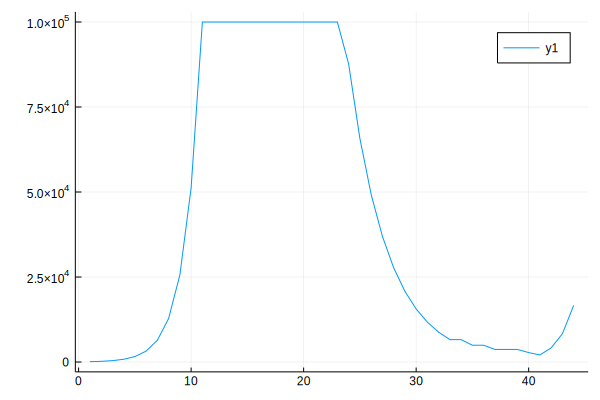

In [54]:
plot(samplingBTR[1])

In [74]:
plot(resultBTR[:DeltaAccumulator])

<!DOCTYPE html>
 
 
 Plots.jl

In [56]:
verbose = true
iterMax = 2000
eps = 1e-4

samplingStrategyIR = Geraldine.InexactRestoration{Geraldine.IndComRN}(Nobs(mo_exp), 1.2)

Geraldine.InexactRestoration{Geraldine.IndComRN,Int64}(100, 100, 100, 100, 100000, Geraldine.NoVariance{Float64}(0.0, 0.0, 0.0, Float64[], Float64[], Float64[]), #undef, ConstantCoeffSubSampling(100, 0.1), Geraldine.var"#58#61"{Int64}(100000), 4.673930583945014e-62, 1.2, 7.731e-320, 0.0)

In [57]:
# BTR
accBtrIR =  Accumulator(ValueAccumulator(), DeltaAccumulator(), FieldAccumulator(:iterCG), ParamAccumulator(), SamplingSize())

"here's an Accumulator"

In [58]:
btr =  Geraldine.BTRStruct(;Nmax=iterMax, eps_g=eps, sam=typeof(samplingStrategyIR))

BTRStruct{Geraldine.TrueHessian{Float64},TruncatedConjugateGradient!{Geraldine.Norm2Constraint},Geraldine.InexactRestoration{Geraldine.IndComRN,Int64}}(TruncatedConjugateGradient!{Geraldine.Norm2Constraint}(Geraldine.stopCGBase, 10), Geraldine.StopParam{Geraldine.ONEVEC{Float64},Float64}([1.0], 1.0, 0.001, 0.0001, 1.0e-6, 2000, 3600.0, 1.0e12))

In [59]:
state, accumulatorBtrIR = btr(mo_exp, copy(x0), samplingStrategyIR, accumulator = accBtrIR, verbose = verbose)

--- Iteration 0 -- Inexact Restoration : 
------ INEXACT Restoration btr ---------- : 
 --- sampling : Geraldine.InexactRestoration{Geraldine.IndComRN,Int64}
-------------------------
initializeState! AbstractStochasticModel -- Inexact Restoration
initializeSampling InexactRestoration! Ind / Com RN

k = 0 -> 1
N previous = 100
N tilde = 120

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 120
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 100
Length shu = 100
- Increase !! with 20
N = 120
Length shu N = 120
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 0  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -4.214984081378808e-11
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
- Step REJECTED !!!! ρ = -0.0984721335292381

 ---  START internal Loop ----

Step accpeted !!! ρ = 0.13530771676371067
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 11
-0.59634518296171
--------------------------------------------------------------------------------

k = 11 -> 12
N previous = 317
N tilde = 381

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 381
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 317
Length shu = 317
- Increase !! with 64
N = 381
Length shu N = 381
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 11  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.023709722885977152
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.3365915376626339
 ---  END internal Loop 

----------------------------------------------

N final = 431
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 359
Length shu = 359
- Increase !! with 72
N = 431
Length shu N = 431
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 20  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.0626021497488136
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.1986251832566871
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 21
-0.6287744026669996
--------------------------------------------------------------------------------

k = 21 -> 22
N previous = 431
N tilde = 518

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 518
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 431
Length shu = 431
-

N tilde = 208

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 208
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 173
Length shu = 173
- Increase !! with 35
N = 208
Length shu N = 208
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 30  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.11345306019434931
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.15338165320687466
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 31
-0.6145875393370257
--------------------------------------------------------------------------------

k = 31 -> 32
N previous = 208
N tilde = 250

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 250
 

N tilde = 579

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 148
 --- updateSample ! InexactRestoration --- Ind / Common Variables
- Decrease !! with 334
N shu = 482
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 42  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.10934063892959237
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.1479139564290675
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 43
-0.5811105439553876
--------------------------------------------------------------------------------

k = 43 -> 44
N previous = 148
N tilde = 178

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 178
 --- updateSample ! InexactRestoration --- Ind / 

N = 317
Length shu N = 317
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 55  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.0183415881416104
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.3807019139171029
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 56
-0.48329960532329713
--------------------------------------------------------------------------------

k = 56 -> 57
N previous = 317
N tilde = 381

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 381
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 317
Length shu = 317
- Increase !! with 64
N = 381
Length shu N = 381
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Opti

 - follow Up 
Step accpeted !!! ρ = 0.1460682561607844
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 69
-0.6109791960756711
--------------------------------------------------------------------------------

k = 69 -> 70
N previous = 230
N tilde = 276

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 276
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 230
Length shu = 230
- Increase !! with 46
N = 276
Length shu N = 276
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 69  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.03130592062192981
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.3015318673929483
 ---  END internal Loop 

--------------------------------

--------------------------------------------------------------------------------

k = 79 -> 80
N previous = 360
N tilde = 432

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 432
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 360
Length shu = 360
- Increase !! with 72
N = 432
Length shu N = 432
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 79  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.03782957256221219
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.2803745918798984
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 80
-0.4445112442394469
--------------------------------------------------------------------------------

k = 80 -> 81
N previous = 432
N

- Increase !! with 30
N = 178
Length shu N = 178
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 88  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.10780304920367813
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.1604499482875762
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 89
-0.6201883825317691
--------------------------------------------------------------------------------

k = 89 -> 90
N previous = 178
N tilde = 214

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 214
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 178
Length shu = 178
- Increase !! with 36
N = 214
Length shu N = 214
updateState! AbstractStochasticModel  -- Inexact Restoration
Tes

κ = -0.03424700886804671
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.3152137296904238
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 98
-0.4798687544858345
--------------------------------------------------------------------------------

k = 98 -> 99
N previous = 183
N tilde = 220

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 220
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 183
Length shu = 183
- Increase !! with 37
N = 220
Length shu N = 220
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 98  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.07154646214163006
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step acc

N tilde = 249

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 249
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 207
Length shu = 207
- Increase !! with 42
N = 249
Length shu N = 249
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 107  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.024093854801586528
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.33535283279960565
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 108
-0.4265586317178731
--------------------------------------------------------------------------------

k = 108 -> 109
N previous = 249
N tilde = 299

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 

--- TCG classic 
κ = -0.03669042657030654
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.29662303161343956
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 118
-0.4495730280383693
--------------------------------------------------------------------------------

k = 118 -> 119
N previous = 479
N tilde = 575

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 144
 --- updateSample ! InexactRestoration --- Ind / Common Variables
- Decrease !! with 335
N shu = 479
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 118  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.10003564459924674
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.154171406

--- TCG classic 
κ = -0.10681345221288438
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.15609491930751793
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 131
-0.6033224806408249
--------------------------------------------------------------------------------

k = 131 -> 132
N previous = 401
N tilde = 482

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 482
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 401
Length shu = 401
- Increase !! with 81
N = 482
Length shu N = 482
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 131  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.026430785678905142
TCG on border
TCG stoped on iteration 1
-------------------------

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 126
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 105
Length shu = 105
- Increase !! with 21
N = 126
Length shu N = 126
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 140  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.123909805574451
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.14788393332391075
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 141
-0.6038795292659846
--------------------------------------------------------------------------------

k = 141 -> 142
N previous = 126
N tilde = 152

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 152
 --- updateSam

N = 249
Length shu N = 249
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 152  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.06503458355610148
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.18277580689650363
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 153
-0.6026323278235957
--------------------------------------------------------------------------------

k = 153 -> 154
N previous = 249
N tilde = 299

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 299
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 249
Length shu = 249
- Increase !! with 50
N = 299
Length shu N = 299
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 --

κ = -0.023959527574236486
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.34636415933330156
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 162
-0.4339989188024993
--------------------------------------------------------------------------------

k = 162 -> 163
N previous = 399
N tilde = 479

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 479
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 399
Length shu = 399
- Increase !! with 80
N = 479
Length shu N = 479
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 162  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.07551279458610752
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
St

--------------------------------------------------------------------------------
Iteration 174
-0.4712281482562666
--------------------------------------------------------------------------------

k = 174 -> 175
N previous = 278
N tilde = 334

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 334
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 278
Length shu = 278
- Increase !! with 56
N = 334
Length shu N = 334
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 174  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.10386835496451963
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.1655983333454247
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 175
-0.63270765747

--------------------------------------------------------------------------------
Iteration 186
-0.4467341024165598
--------------------------------------------------------------------------------

k = 186 -> 187
N previous = 126
N tilde = 152

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 152
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 126
Length shu = 126
- Increase !! with 26
N = 152
Length shu N = 152
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 186  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.0964816339172763
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.1632867235330772
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 187
-0.605343358310

N tilde = 207

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 207
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 172
Length shu = 172
- Increase !! with 35
N = 207
Length shu N = 207
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 196  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.11921006288287093
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.1503426610713249
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 197
-0.6075229472441216
--------------------------------------------------------------------------------

k = 197 -> 198
N previous = 207
N tilde = 249

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 24

N = 332
Length shu N = 332
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 205  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.040169747144566656
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.28535902005684505
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 206
-0.4654386697529603
--------------------------------------------------------------------------------

k = 206 -> 207
N previous = 332
N tilde = 399

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 399
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 332
Length shu = 332
- Increase !! with 67
N = 399
Length shu N = 399
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -

--- TCG classic 
κ = -0.09015973050040202
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.17017068281144607
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 215
-0.613216871650642
--------------------------------------------------------------------------------

k = 215 -> 216
N previous = 432
N tilde = 519

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 519
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 432
Length shu = 432
- Increase !! with 87
N = 519
Length shu N = 519
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 215  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.021258804032531012
TCG on border
TCG stoped on iteration 1
-------------------------


N previous = 257
N tilde = 309

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 309
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 257
Length shu = 257
- Increase !! with 52
N = 309
Length shu N = 309
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 226  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.13787901218880735
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.14337831540347729
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 227
-0.6177330830118366
--------------------------------------------------------------------------------

k = 227 -> 228
N previous = 309
N tilde = 371

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 --------------

κ = -0.024182055672052623
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.33610434628688646
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 236
-0.4576168878897574
--------------------------------------------------------------------------------

k = 236 -> 237
N previous = 317
N tilde = 381

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 381
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 317
Length shu = 317
- Increase !! with 64
N = 381
Length shu N = 381
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 236  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.14991993011856813
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
St

κ = -0.13910015574028
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.13975687175644552
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 247
-0.6059328086431391
--------------------------------------------------------------------------------

k = 247 -> 248
N previous = 518
N tilde = 622

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 191
 --- updateSample ! InexactRestoration --- Ind / Common Variables
- Decrease !! with 327
N shu = 518
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 247  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.042239649326921785
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.28641871199926994
 ---  END 

--------------------------------------------------------------------------------

k = 256 -> 257
N previous = 208
N tilde = 250

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 250
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 208
Length shu = 208
- Increase !! with 42
N = 250
Length shu N = 250
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 256  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.055702578189579105
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.18472578417699168
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 257
-0.5877969836093171
--------------------------------------------------------------------------------

k = 257 -> 258
N previous

Nmax reached ? 
k = 266  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.08872364996194498
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.1686831947839344
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 267
-0.6065799383976794
--------------------------------------------------------------------------------

k = 267 -> 268
N previous = 482
N tilde = 579

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 148
 --- updateSample ! InexactRestoration --- Ind / Common Variables
- Decrease !! with 334
N shu = 482
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 267  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.04425251658437626
TCG on border

κ = -0.06436397411995376
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.18971676455271588
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 279
-0.6132467604137833
--------------------------------------------------------------------------------

k = 279 -> 280
N previous = 220
N tilde = 264

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 264
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 220
Length shu = 220
- Increase !! with 44
N = 264
Length shu N = 264
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 279  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.023325739754029975
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
St

--------------------------------------------------------------------------------
Iteration 289
-0.6049000133596195
--------------------------------------------------------------------------------

k = 289 -> 290
N previous = 299
N tilde = 359

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 359
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 299
Length shu = 299
- Increase !! with 60
N = 359
Length shu N = 359
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 289  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.01936096870196329
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.36819694183098317
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 290
-0.4431274206

N = 173
Length shu N = 173
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 299  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.022097554014723336
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.3408642723220732
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 300
-0.3991884783524538
--------------------------------------------------------------------------------

k = 300 -> 301
N previous = 173
N tilde = 208

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 208
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 173
Length shu = 173
- Increase !! with 35
N = 208
Length shu N = 208
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 --

-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.2034203782505138
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 309
-0.6036765787967598
--------------------------------------------------------------------------------

k = 309 -> 310
N previous = 278
N tilde = 334

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 334
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 278
Length shu = 278
- Increase !! with 56
N = 334
Length shu N = 334
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 309  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.030425402738149525
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.307007447983317
 ---  END internal Loop 

--

- Increase !! with 31
N = 183
Length shu N = 183
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 322  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.1255960855109169
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.14416971106905238
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 323
-0.5966411497657039
--------------------------------------------------------------------------------

k = 323 -> 324
N previous = 183
N tilde = 220

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 220
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 183
Length shu = 183
- Increase !! with 37
N = 220
Length shu N = 220
updateState! AbstractStochasticModel  -- Inexact Restoration

 - follow Up 
Step accpeted !!! ρ = 0.26109956865121403
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 332
-0.3796002758317622
--------------------------------------------------------------------------------

k = 332 -> 333
N previous = 207
N tilde = 249

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 249
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 207
Length shu = 207
- Increase !! with 42
N = 249
Length shu N = 249
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 332  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.12601432860673845
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.13268219463074452
 ---  END internal Loop 

--------------------------

computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.03402047441927926
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.3016684742054197
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 342
-0.44358134922847303
--------------------------------------------------------------------------------

k = 342 -> 343
N previous = 399
N tilde = 479

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 479
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 399
Length shu = 399
- Increase !! with 80
N = 479
Length shu N = 479
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 342  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.09843223353648384
TCG on

N = 231
Length shu N = 231
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 352  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.12018509544319805
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.15091165421517772
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 353
-0.6138313841503577
--------------------------------------------------------------------------------

k = 353 -> 354
N previous = 231
N tilde = 278

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 278
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 231
Length shu = 231
- Increase !! with 47
N = 278
Length shu N = 278
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 --

N final = 446
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 371
Length shu = 371
- Increase !! with 75
N = 446
Length shu N = 446
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 363  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.03141924509539007
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.31747756333018917
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 364
-0.4562086702700023
--------------------------------------------------------------------------------

k = 364 -> 365
N previous = 446
N tilde = 536

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 105
 --- updateSample ! InexactRestoration --- Ind / Common Variables
- Decrease !! with 341
N shu

 -- Optimality Inexact Restoration
Nmax reached ? 
k = 372  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.13762436449194526
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.1396093035330767
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 373
-0.6006435715056057
--------------------------------------------------------------------------------

k = 373 -> 374
N previous = 458
N tilde = 550

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 119
 --- updateSample ! InexactRestoration --- Ind / Common Variables
- Decrease !! with 339
N shu = 458
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 373  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ =

- Increase !! with 46
N = 276
Length shu N = 276
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 384  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.10389594422125269
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.16237512754490338
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 385
-0.6237513090619409
--------------------------------------------------------------------------------

k = 385 -> 386
N previous = 276
N tilde = 332

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 332
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 276
Length shu = 276
- Increase !! with 56
N = 332
Length shu N = 332
updateState! AbstractStochasticModel  -- Inexact Restoratio

- Increase !! with 72
N = 432
Length shu N = 432
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 394  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.07954914061694952
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.18155875830440713
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 395
-0.6256565034592527
--------------------------------------------------------------------------------

k = 395 -> 396
N previous = 432
N tilde = 519

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 519
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 432
Length shu = 432
- Increase !! with 87
N = 519
Length shu N = 519
updateState! AbstractStochasticModel  -- Inexact Restoratio

N = 214
Length shu N = 214
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 404  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.14992689103243367
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.1403557748634408
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 405
-0.6373293874331453
--------------------------------------------------------------------------------

k = 405 -> 406
N previous = 214
N tilde = 257

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 257
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 214
Length shu = 214
- Increase !! with 43
N = 257
Length shu N = 257
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- 

--- TCG classic 
κ = -0.02374228989354797
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.3431861258517506
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 414
-0.49593718654898356
--------------------------------------------------------------------------------

k = 414 -> 415
N previous = 220
N tilde = 264

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 264
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 220
Length shu = 220
- Increase !! with 44
N = 264
Length shu N = 264
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 414  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.015873663984930245
TCG on border
TCG stoped on iteration 1
-------------------------

κ = -0.026135134024896364
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.3261765428423419
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 424
-0.4314575354026181
--------------------------------------------------------------------------------

k = 424 -> 425
N previous = 299
N tilde = 359

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 359
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 299
Length shu = 299
- Increase !! with 60
N = 359
Length shu N = 359
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 424  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.12740668095103125
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Ste

--- TCG classic 
κ = -0.11198431566552867
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.1579271717135908
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 435
-0.6227840386044162
--------------------------------------------------------------------------------

k = 435 -> 436
N previous = 173
N tilde = 208

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 208
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 173
Length shu = 173
- Increase !! with 35
N = 208
Length shu N = 208
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 435  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.020254966755580146
TCG on border
TCG stoped on iteration 1
-------------------------


N = 178
Length shu N = 178
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 448  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.07745561679112442
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.17973550922633308
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 449
-0.6104351449065465
--------------------------------------------------------------------------------

k = 449 -> 450
N previous = 178
N tilde = 214

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 214
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 178
Length shu = 178
- Increase !! with 36
N = 214
Length shu N = 214
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 --

--- TCG classic 
κ = -0.02218610407538227
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.33018386058385274
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 458
-0.454256175513479
--------------------------------------------------------------------------------

k = 458 -> 459
N previous = 183
N tilde = 220

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 220
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 183
Length shu = 183
- Increase !! with 37
N = 220
Length shu N = 220
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 458  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.10437139928768245
TCG on border
TCG stoped on iteration 1
-------------------------
 

N = 249
Length shu N = 249
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 467  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.023697816274071817
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.3450336690078119
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 468
-0.48925571224054
--------------------------------------------------------------------------------

k = 468 -> 469
N previous = 249
N tilde = 299

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 299
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 249
Length shu = 249
- Increase !! with 50
N = 299
Length shu N = 299
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- O

k = 479  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.031110633374257526
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.3223993350533167
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 480
-0.44082734890206254
--------------------------------------------------------------------------------

k = 480 -> 481
N previous = 173
N tilde = 208

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 208
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 173
Length shu = 173
- Increase !! with 35
N = 208
Length shu N = 208
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 480  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -

 - follow Up 
Step accpeted !!! ρ = 0.1739148628716762
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 491
-0.582888869232156
--------------------------------------------------------------------------------

k = 491 -> 492
N previous = 401
N tilde = 482

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 482
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 401
Length shu = 401
- Increase !! with 81
N = 482
Length shu N = 482
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 491  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.02286068247212307
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.33410283861660145
 ---  END internal Loop 

----------------------------

N = 126
Length shu N = 126
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 500  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.10979319954001689
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.14642038659546772
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 501
-0.5738177747427137
--------------------------------------------------------------------------------

k = 501 -> 502
N previous = 126
N tilde = 152

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 152
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 126
Length shu = 126
- Increase !! with 26
N = 152
Length shu N = 152
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 --

N = 299
Length shu N = 299
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 513  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.027737055403026564
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.3343406007668393
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 514
-0.4795595991840629
--------------------------------------------------------------------------------

k = 514 -> 515
N previous = 299
N tilde = 359

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 359
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 299
Length shu = 299
- Increase !! with 60
N = 359
Length shu N = 359
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 --

Iteration 523
-0.6176984631245195
--------------------------------------------------------------------------------

k = 523 -> 524
N previous = 479
N tilde = 575

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 144
 --- updateSample ! InexactRestoration --- Ind / Common Variables
- Decrease !! with 335
N shu = 479
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 523  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.026571763400966855
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.33964024420009975
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 524
-0.46607645583380275
--------------------------------------------------------------------------------

k = 524 -> 525
N previous = 144
N til

Length shu = 192
- Increase !! with 39
N = 231
Length shu N = 231
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 532  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.11870935446738229
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.15078312556860715
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 533
-0.6085883833544653
--------------------------------------------------------------------------------

k = 533 -> 534
N previous = 231
N tilde = 278

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 278
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 231
Length shu = 231
- Increase !! with 47
N = 278
Length shu N = 278
updateState! AbstractStochasticModel  -- I

k = 541  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.03172907826527879
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.3164786255427875
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 542
-0.44641361302326693
--------------------------------------------------------------------------------

k = 542 -> 543
N previous = 309
N tilde = 371

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 371
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 309
Length shu = 309
- Increase !! with 62
N = 371
Length shu N = 371
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 542  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0

N final = 458
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 381
Length shu = 381
- Increase !! with 77
N = 458
Length shu N = 458
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 552  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.11054321560005706
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.15318102125087593
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 553
-0.6005314508441856
--------------------------------------------------------------------------------

k = 553 -> 554
N previous = 458
N tilde = 550

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 119
 --- updateSample ! InexactRestoration --- Ind / Common Variables
- Decrease !! with 339
N shu

κ = -0.06467870503149867
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.1972525907568997
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 563
-0.6290678104203399
--------------------------------------------------------------------------------

k = 563 -> 564
N previous = 191
N tilde = 230

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 230
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 191
Length shu = 191
- Increase !! with 39
N = 230
Length shu N = 230
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 563  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.018003698829783452
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Ste

- Increase !! with 72
N = 432
Length shu N = 432
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 574  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.11717075880860481
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.15865164010061378
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 575
-0.6374670716647475
--------------------------------------------------------------------------------

k = 575 -> 576
N previous = 432
N tilde = 519

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 519
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 432
Length shu = 432
- Increase !! with 87
N = 519
Length shu N = 519
updateState! AbstractStochasticModel  -- Inexact Restoratio

 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 585
-0.5464603898948484
--------------------------------------------------------------------------------

k = 585 -> 586
N previous = 214
N tilde = 257

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 257
 --- updateSample ! InexactRestoration --- Ind / Common Variables
Nprevious = 214
Length shu = 214
- Increase !! with 43
N = 257
Length shu N = 257
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 585  and  max = 2000
computecand! AbstractStochasticModel -- Inexact Restoration
--- TCG classic 
κ = -0.04510197922381484
TCG on border
TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.25586093353806405
 ---  END internal Loop 

--------------------------------------------------------------------------------
I

Excessive output truncated after 524322 bytes.


TCG stoped on iteration 1
-------------------------
 - follow Up 
Step accpeted !!! ρ = 0.13339544951131926
 ---  END internal Loop 

--------------------------------------------------------------------------------
Iteration 589
-0.5622244757255598
--------------------------------------------------------------------------------

k = 589 -> 590
N previous = 446
N tilde = 536

 ---  START internal Loop ---- 
 ---- ------ internal Tau : 0 -------------------
N final = 105
 --- updateSample ! InexactRestoration --- Ind / Common Variables
- Decrease !! with 341
N shu = 446
updateState! AbstractStochasticModel  -- Inexact Restoration
Tests arret !!!!
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 589  and  max = 2000


"here's a state""here's an Accumulator"

In [66]:
 # Collecting results
 resultIR = Geraldine.structToDict(accumulatorBtrIR)

samplingIR = resultIR[:SamplingSizeAccumulator]
fIR = resultIR[:ValueAccumulator]
paramIR = resultIR[:ParamAccumulator]

790-element Array{Array{T,1} where T,1}:
 [22.545278228811334, 19.09856045400314]
 [20.63772178586085, 17.482630871082495]
 [18.730165342910368, 15.866701288161849]
 [16.82260889995988, 14.250771705241203]
 [14.5335411684193, 12.311656205736428]
 [12.244473436878717, 10.372540706231652]
 [9.955405705338135, 8.433425206726875]
 [7.666337973797553, 6.4943097072221]
 [5.377270242256971, 4.555194207717324]
 [2.6303889644082736, 2.228255608311594]
 [-0.665868569010164, -0.5640707109752823]
 [0.9822601976990557, 0.8320924486681547]
 [-0.6658685690101651, -0.5640707109752805]
 ⋮
 [3.708366159931753e-157, 3.141431858689142e-157]
 [3.708366159931753e-157, 3.141431858689142e-157]
 [3.708366159931753e-157, 3.141431858689142e-157]
 [3.708366159931753e-157, 3.141431858689142e-157]
 [3.708366159931753e-157, 3.141431858689142e-157]
 [3.708366159931753e-157, 3.141431858689142e-157]
 [3.708366159931753e-157, 3.141431858689142e-157]
 [3.708366159931753e-157, 3.141431858689142e-157]
 [3.708366159931753e-

In [88]:
paramIR[600]

2-element Array{Float64,1}:
 6.937759222039438e-9
 5.877115934103405e-9

In [61]:
gr()

Plots.GRBackend()

In [77]:
plot(samplingIR[1], legend=false, title="Sample size IR")

<!DOCTYPE html>
 
 
 Plots.jl

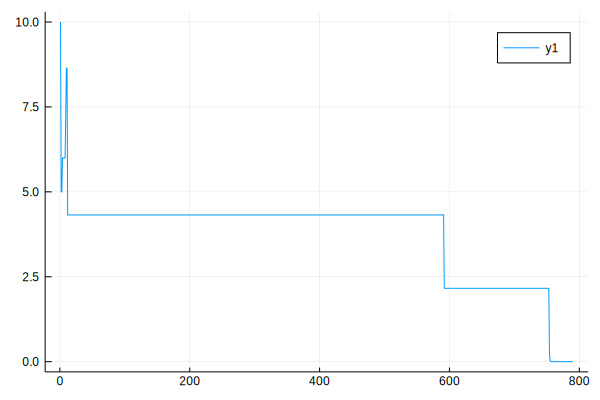

In [68]:
plot(resultIR[:DeltaAccumulator], )

In [72]:
plotly()

Plots.PlotlyBackend()

In [73]:
p = scatter(getindex.(paramBTR, 1), getindex.(paramBTR, 2), label="BTR", legend=:topleft)
scatter!(getindex.(paramIR, 1), getindex.(paramIR, 2), label = "IR")
scatter!(getindex.(paramSGD, 1), getindex.(paramSGD, 2), label="SGD")

<!DOCTYPE html>
 
 
 Plots.jl

In [19]:
x = range(-2,stop=25,length=50)
y = range(-2,stop=25,length=50)
p = contour(x,y, (x,y)->Sofia.F([x;y], mo_exp), levels=100)

scatter!(p, getindex.(paramBTR, 1), getindex.(paramBTR, 2))
scatter!(p, getindex.(paramSGD, 1), getindex.(paramSGD, 2))

LoadError: [91mUndefVarError: paramBTR not defined[39m